# 1. Getting VizDoom Up and Running

In [9]:
# !pip install vizdoom

149.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [2]:
# !cd github & git clone https://github.com/mwydmuch/VizDoom

In [18]:
from vizdoom import *
import random
import time 
import numpy as np

In [30]:
game = DoomGame()
game.load_config('github/VizDoom/scenarios/deadly_corridor.cfg')
game.add_available_game_variable(GameVariable.HITCOUNT)
game.init()

# Do not close the windows now

In [27]:
import numpy as np
# 3 possible actions: left, right, attack
actions =  np.identity(7, dtype=np.uint8) 
# game.make_action(random.choice(actions))
state = game.get_state()

In [31]:
episodes = 1

for episode in range(episodes):
    game.new_episode()
    #state = game.get_state()
    #var = state.game_variables
    #print(var, var[0], var[1])
    while not game. is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables   
        reward = game.make_action(random.choice(actions))
        print('Reward: ', reward)
        print(info)
        time.sleep(0.02)
    print('result: ', game.get_total_reward())
    time.sleep(2)

[100.   0.] 100.0 0.0
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.0
[100.   0.]
Reward:  0.78125
[100.   0.]
Reward:  1.4892578125
[100.   0.]
Reward:  1.349639892578125
[100.   0.]
Reward:  2.0043487548828125
[100.   0.]
Reward:  1.816436767578125
[100.   0.]
Reward:  1.6461334228515625
[100.   0.]
Reward:  2.2715301513671875
[100.   0.]
Reward:  2.838287353515625
[100.   0.]
Reward:  3.3519134521484375
[100.   0.]
Reward:  2.991668701171875
[100.   0.]
Reward:  0.0330047607421875
[70.  0.]
Reward:  0.80963134765625
[70.  0.]
Reward:  -0.0460205078125
[70.  0.]
Reward:  -0.8214569091796875
[70.  0.]
Reward:  -0.74444580078125
[70.  0.]
Reward:  -0.7436065673828125
[70.  0.]
Reward:  -1.4517822265625
[70.  0.]
Reward:  -1.3156890869140625
[70.  0.]
Reward:  -1.9702301025390625
[70.  0.]
Reward:  -2.5634002685546875
[70.  0.]
Reward:  -3.1009674072265625
[70.  0.]
Reward:

In [32]:
game.close()

# 2. Converting it to a Gym Env

In [14]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2 # for making image grey scale and thus increase training speed

In [15]:
Box(low=0, high=10,shape=(5,5), dtype=np.uint8).sample()

array([[ 7,  4,  9,  5,  4],
       [10,  3,  9,  3,  7],
       [10,  1,  7,  6,  1],
       [10,  5,  7,  6,  1],
       [ 7,  0,  2,  0,  3]], dtype=uint8)

In [58]:
class VizDoomGym(Env):
    def __init__(self, render=False, config='s4'):
        super().__init__()
        self.game = DoomGame()
        config_file = 'github/VizDoom/scenarios/deadly_corridor_%s.cfg' % config
        self.game.load_config(config_file)
        self.game.set_window_visible(render)
        
        self.game.add_available_game_variable(GameVariable.DAMAGE_TAKEN)
        self.game.add_available_game_variable(GameVariable.DAMAGECOUNT)
        self.game.add_available_game_variable(GameVariable.AMMO1)
        self.game.init()
        
        #print(self.game.get_available_game_variables())
        #print(self.game.get_state().game_variables)
        
        # get shape: game.get_state().screen_buffer.shape
        self.observation_space = \
            Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
            # Box(low=0, high=255, shape=(3, 240, 320), dtype=np.uint8) 
        self.action_space = Discrete(7)

        self.damage_taken = 0
        self.hit_count = 0
        self.ammo = 52
 
 
    def step(self, action : int):
        actions = np.identity(7, dtype=np.uint8)
        # 4 is a frame-skip parameter
        move_reward = self.game.make_action(actions[action], 4)
        reward = 0
        
        state  = self.game.get_state()
        if state:
            img  = state.screen_buffer # actually the next frame
            img  = self.grayscale(img)

            vars = state.game_variables
            health = vars[0]
            damage_taken = vars[1]
            damage_count = vars[2]
            ammo  = vars[3]
            damage_delta    = self.damage_taken - damage_taken
            damage_count_delta = damage_count - self.hit_count
            ammo_delta      = ammo - self.ammo
            self.hit_count    = damage_count
            self.damage_taken = damage_taken
            self.ammo         = ammo

            # Reward design
            reward = move_reward + damage_delta * 10 + \
                damage_count_delta * 200 + ammo_delta * 10

            info = vars

        else:
            img  = np.zeros(self.observation_space.shape)
            info = [0, 0, 0, -1]
            
        done = self.game.is_episode_finished()
        truncated = False

        return img, reward, done, truncated, {'info': info}


    def close(self):
        self.game.close()
        
        
    def render():
        pass


    def grayscale(self, observation):
        # moveaxis: tensor of shape (3, 240, 320) --> (240, 320, 3)
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), 
                            cv2.COLOR_BGR2GRAY)
        # reduce resolution
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        img = np.reshape(resize, (100, 160, 1))
        return img

    def reset(self, seed=0):
        self.game.new_episode()
        self.damage_taken = 0
        self.hit_count = 0
        self.ammo = 52
 
        img  = self.game.get_state().screen_buffer
        info = self.game.get_state().game_variables
        info =  {'info': info}
        return (self.grayscale(img), info)

In [59]:
from stable_baselines3.common import env_checker

env = VizDoomGym()
env_checker.check_env(env)

In [60]:
env = VizDoomGym(render=True)

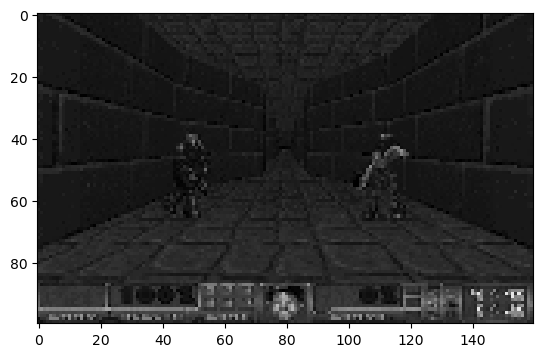

In [61]:
img, info = env.reset()

img.shape
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [62]:
env.close()

# Setup Callback

In [63]:
import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None: 
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,
                'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

CHECKPOINT_DIR = './train/deadly_corridor'
LOG_DIR = './logs/deadly_corridor'

In [64]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model 

In [65]:
from stable_baselines3 import PPO

env = VizDoomGym(render=False, config='s1')
model = PPO('CnnPolicy', env, device='cuda', tensorboard_log=LOG_DIR, verbose=1, 
            learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=0.95, gae_lambda=.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [66]:
# Do not start training from a previous (bad) model
model.learn(total_timesteps=400000, reset_num_timesteps=False, callback=callback)

Logging to ./logs/deadly_corridor/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 197      |
|    ep_rew_mean     | 1.2e+03  |
| time/              |          |
|    fps             | 841      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 237         |
|    ep_rew_mean          | 1.49e+03    |
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.003561974 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 4.65

In [69]:
model = PPO.load(CHECKPOINT_DIR+'/best_model_400000')
env = VizDoomGym(render=False, config='s3')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/deadly_corridor/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 94.6     |
|    ep_rew_mean     | 5.98e+03 |
| time/              |          |
|    fps             | 831      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 105         |
|    ep_rew_mean          | 7.03e+03    |
| time/                   |             |
|    fps                  | 717         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008743848 |
|    clip_fraction        | 0.297       

In [70]:
env = VizDoomGym(render=False, config='s4')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/deadly_corridor/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 62.2     |
|    ep_rew_mean     | 4.27e+03 |
| time/              |          |
|    fps             | 844      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 8192     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 57.9      |
|    ep_rew_mean          | 4.12e+03  |
| time/                   |           |
|    fps                  | 714       |
|    iterations           | 2         |
|    time_elapsed         | 22        |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 0.0166661 |
|    clip_fraction        | 0.383     |
|    clip_range       

In [72]:
env = VizDoomGym(render=False, config='s5')
model.set_env(env)
model.learn(total_timesteps=40000, callback=callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/deadly_corridor/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 61.9     |
|    ep_rew_mean     | 4.85e+03 |
| time/              |          |
|    fps             | 771      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 73.2        |
|    ep_rew_mean          | 5.6e+03     |
| time/                   |             |
|    fps                  | 661         |
|    iterations           | 2           |
|    time_elapsed         | 24          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.009405252 |
|    clip_fraction        | 0.285       

# Test the Model

In [73]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

model = PPO.load(CHECKPOINT_DIR+'/best_model_520000')
env = VizDoomGym(render=True, config='s5')
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

print(mean_reward)
env.close()

8645.484559631348


In [74]:
# Or we can write our own logic

env = VizDoomGym(render=True)
total_reward = 0

for episode in range(10):
    obs = env.reset()[0]
    done = False 
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        time.sleep(0.05)
        total_reward += reward
    print(total_reward)
    time.sleep(2)

env.close()

2087.07763671875
15118.50210571289
26321.811065673828
28154.122100830078
35413.46936035156
40446.99533081055
46737.2405090332
50797.188568115234
52661.267349243164
67502.31430053711
